# Facial Expression Recognition

## 1. Introduction

### Facial emotion recognition is one of the most interesting research areas in which artificial intelligence and human psychology are combined to understand emotions through facial expressions. This project focuses on analyzing and classifying emotions like happiness, sadness, anger, neutral, disgust, contempt, fear, and surprise by interpreting facial features using advanced algorithms.

### What's the main topic?

#### Our topic is Facial Emotion Recognition, which involves the identification and classification of emotions using facial expressions through machine learning and deep learning techniques. This technology aspires to bridge the gap between human emotions and artificial intelligence, making systems understand and respond to human feelings in a more empathetic and personalized manner. With its wide range of applications, including healthcare, customer service, and security, facial emotion recognition can enhance user experiences by providing more tailored and responsive interactions.

### What questions are we trying to answer with our analysis?

### The questions that this project will answer are as follows:
- How can facial emotion recognition systems be integrated into everyday AI applications to make them more responsive to human emotions and needs?
- What are the contributions of emotion recognition to the improvement of user experience and personalization of interactions in healthcare, customer service, and entertainment?
- How can ethical issues of facial emotion recognition be addressed in order to make sure that this technology is used responsibly and does not infringe on privacy or promote bias?

### Why are these questions significant?

### Developing empathetic and emotionally aware AI is vital for improving human-computer interactions. Addressing ethical concerns and ensuring fairness will enhance user experiences in areas like mental health support, personalized customer service, and secure applications, enabling responsible deployment across diverse sectors.

##  Data preprocessing and Data Cleaning

In [2]:
# Importing the required Libraries
import os
import shutil
import pandas as pd
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
import hashlib
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.optim import lr_scheduler
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader,SubsetRandomSampler,ConcatDataset
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array, load_img

In [3]:
train_path = r'C:\Users\Harshitha GR\Desktop\saee\train'
val_path = r'C:\Users\Harshitha GR\Desktop\saee\val'

#### This code initializes two ImageDataGenerator instances for handling training and validation image datasets in a deep learning context.
#### Both generators load images from specified directories, resize them to 48x48 pixels, and classify them as grayscale and categorical for multi-class classification tasks, preparing the data for a convolutional neural network (CNN) training pipeline.

In [4]:
# Creating ImageDataGenerator for training and validation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Loading the training images
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(48, 48),
    batch_size=128,
    color_mode='grayscale',  # Use grayscale since the images are grayscale
    class_mode='categorical'
)

# Loading the validation images
validation_generator = val_datagen.flow_from_directory(
    val_path,
    target_size=(48, 48),
    batch_size=128,
    color_mode='grayscale',
    class_mode='categorical'
)


Found 31259 images belonging to 8 classes.
Found 8077 images belonging to 8 classes.


In [5]:
# Checking the number of classes and samples in the training and validation sets
print("Training Classes and Counts:")
for class_name, count in train_generator.class_indices.items():
    print(f"{class_name}: {len(os.listdir(os.path.join(train_path, class_name)))}")

print("\nValidation Classes and Counts:")
for class_name, count in validation_generator.class_indices.items():
    print(f"{class_name}: {len(os.listdir(os.path.join(val_path, class_name)))}")


Training Classes and Counts:
ANGER: 3820
CONTEMPT: 2018
DISGUST: 2155
FEAR: 3896
HAPPINESS: 7069
NEUTRAL: 4853
SADNESS: 4747
SURPRISE: 2701

Validation Classes and Counts:
ANGER: 977
CONTEMPT: 521
DISGUST: 561
FEAR: 1013
HAPPINESS: 1789
NEUTRAL: 1234
SADNESS: 1214
SURPRISE: 768


#### The provided code defines two functions for identifying duplicate images and unwanted files in specified directories. The hash_image function generates a unique hash for each image by resizing it and converting it to bytes. The check_duplicates_and_unwanted_files function traverses a directory, checks each file's extension, and uses the hash function to detect duplicates, storing paths of duplicates and unwanted files separately.

In [6]:
def hash_image(file_path):
    with Image.open(file_path) as img:
        img = img.convert('RGB').resize((48, 48))
        img_bytes = img.tobytes()
        return hashlib.md5(img_bytes).hexdigest()

def check_duplicates_and_unwanted_files(directory):
    seen_hashes = set()
    duplicate_files = []
    unwanted_files = []

    for subdir, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(subdir, file)
            if not file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif')):
                unwanted_files.append(file_path)
                continue

            try:
                img_hash = hash_image(file_path)
                if img_hash in seen_hashes:
                    duplicate_files.append(file_path)
                else:
                    seen_hashes.add(img_hash)
            except Exception as e:
                print(f"Error processing {file_path}: {e}")

    return duplicate_files, unwanted_files

# Checking duplicates and unwanted files in the training and validation directories
train_duplicates, train_unwanted = check_duplicates_and_unwanted_files(train_path)
val_duplicates, val_unwanted = check_duplicates_and_unwanted_files(val_path)

print(f"Training Duplicates: {len(train_duplicates)}")

print(f"\nTraining Unwanted Files:{len(train_unwanted)}")

print(f"\nValidation Duplicates:{len(val_duplicates)}")

print(f"\nValidation Unwanted Files:{len(val_unwanted)}")

Training Duplicates: 0

Training Unwanted Files:0

Validation Duplicates:0

Validation Unwanted Files:1


In [7]:
def remove_duplicates(duplicate_files):
    """Remove duplicate files from the dataset."""
    for file_path in duplicate_files:
        try:
            os.remove(file_path)
            #print(f"Removed duplicate: {file_path}")
        except Exception as e:
            print(f"Error removing {file_path}: {e}")

# Remove duplicates from the training set
array = [train_duplicates, train_unwanted, val_duplicates, val_unwanted]
for i in array:
  remove_duplicates(i)

print("Duplicate images have been removed.")
print(f"Training Duplicates: {len(train_duplicates)}")

print(f"\nTraining Unwanted Files:{len(train_unwanted)}")

print(f"\nValidation Duplicates:{len(val_duplicates)}")

print(f"\nValidation Unwanted Files:{len(val_unwanted)}")

Duplicate images have been removed.
Training Duplicates: 0

Training Unwanted Files:0

Validation Duplicates:0

Validation Unwanted Files:1


In [8]:
train_generator1 = train_datagen.flow_from_directory(
    train_path,
    target_size=(48, 48),
    batch_size=128,
    color_mode='rgb',
    class_mode='categorical'
)

# Loading the validation images
validation_generator1 = val_datagen.flow_from_directory(
    val_path,
    target_size=(48, 48),
    batch_size=64,
    color_mode='rgb',
    class_mode='categorical'
)

print(f"Number of training images: {train_generator1.samples}")
print(f"Number of validation images: {validation_generator1.samples}")
print(f"Number of classes: {len(train_generator1.class_indices)}")

print("Class Labels:")
for label, index in train_generator1.class_indices.items():
    print(f"{index}: {label}")

Found 31259 images belonging to 8 classes.
Found 8077 images belonging to 8 classes.
Number of training images: 31259
Number of validation images: 8077
Number of classes: 8
Class Labels:
0: ANGER
1: CONTEMPT
2: DISGUST
3: FEAR
4: HAPPINESS
5: NEUTRAL
6: SADNESS
7: SURPRISE


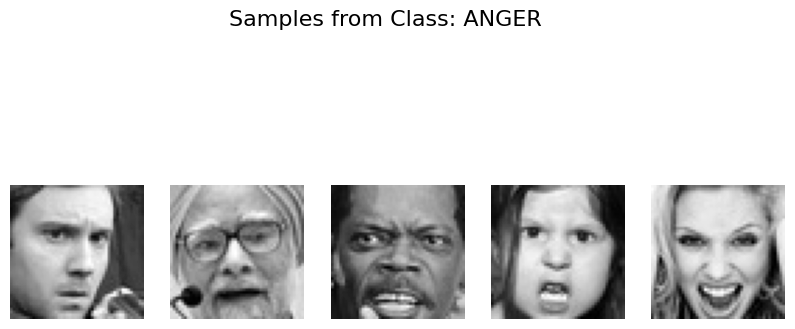

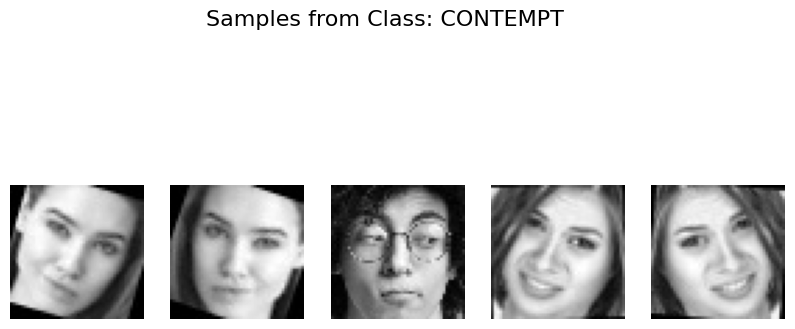

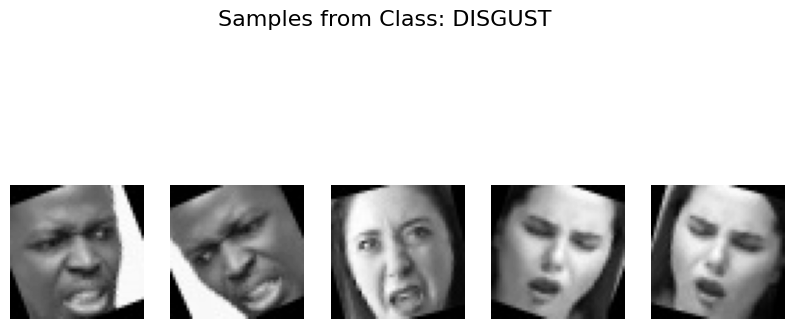

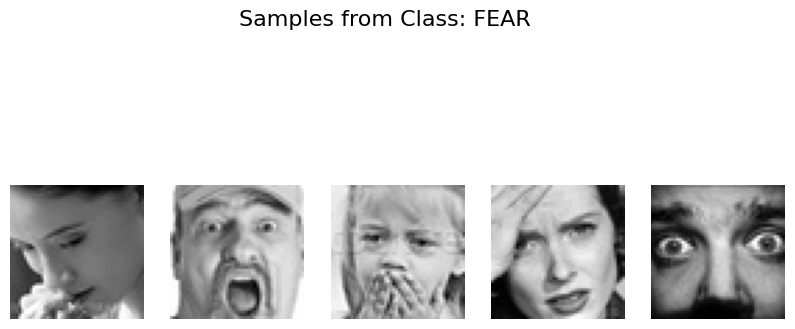

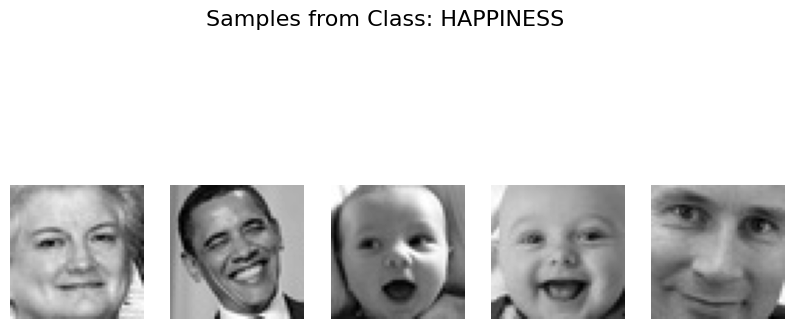

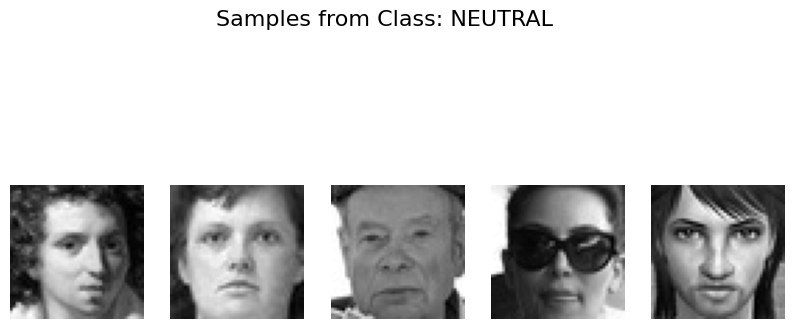

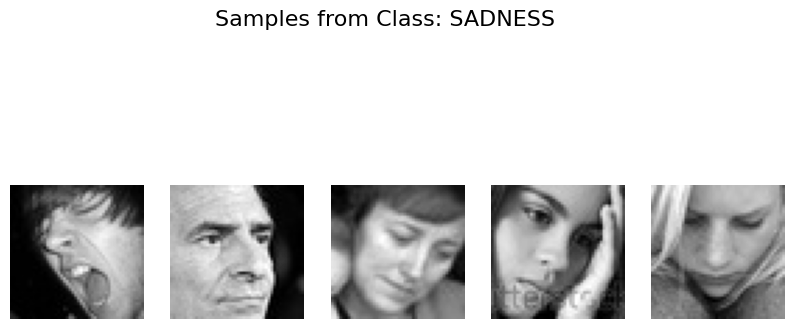

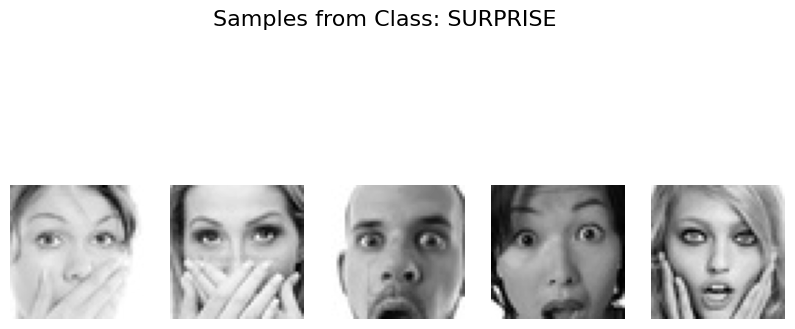

In [9]:
def plot_sample_images(generator, class_labels, num_samples=5):
    """Plot sample images from each class."""
    for class_label in class_labels:
        plt.figure(figsize=(10, 5))
        plt.suptitle(f"Samples from Class: {class_label}", fontsize=16)

        # Get image paths for the class
        class_dir = os.path.join(train_path, class_label)
        image_files = os.listdir(class_dir)

        for i in range(num_samples):
            img_path = os.path.join(class_dir, image_files[i])
            img = plt.imread(img_path)
            plt.subplot(1, num_samples, i + 1)
            plt.imshow(img, cmap='gray')
            plt.axis('off')

        plt.show()

# Plotting five sample images from each class
plot_sample_images(train_generator1.class_indices.keys(), train_generator1.class_indices.keys())


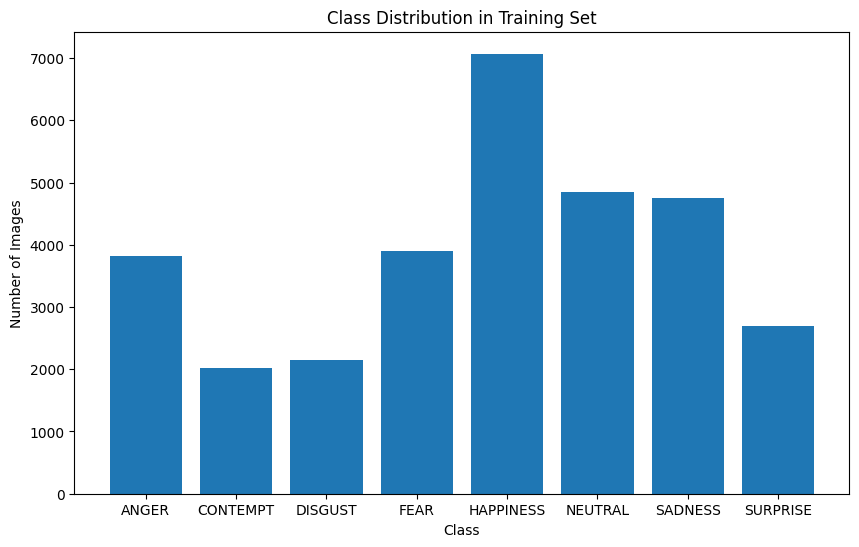

In [10]:
import matplotlib.pyplot as plt

class_counts = [len(os.listdir(os.path.join(train_path, class_name))) for class_name in train_generator1.class_indices.keys()]

plt.figure(figsize=(10, 6))
plt.bar(train_generator1.class_indices.keys(), class_counts)
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Class Distribution in Training Set')
plt.show()

In [11]:
total_images = sum(class_counts)
class_distribution = {label: count / total_images * 100 for label, count in zip(train_generator1.class_indices.keys(), class_counts)}
print(class_distribution)


{'ANGER': 12.220480501615533, 'CONTEMPT': 6.455740746664961, 'DISGUST': 6.894014523817141, 'FEAR': 12.463610480181709, 'HAPPINESS': 22.61428708531943, 'NEUTRAL': 15.52512876291628, 'SADNESS': 15.186026424389777, 'SURPRISE': 8.640711475095172}


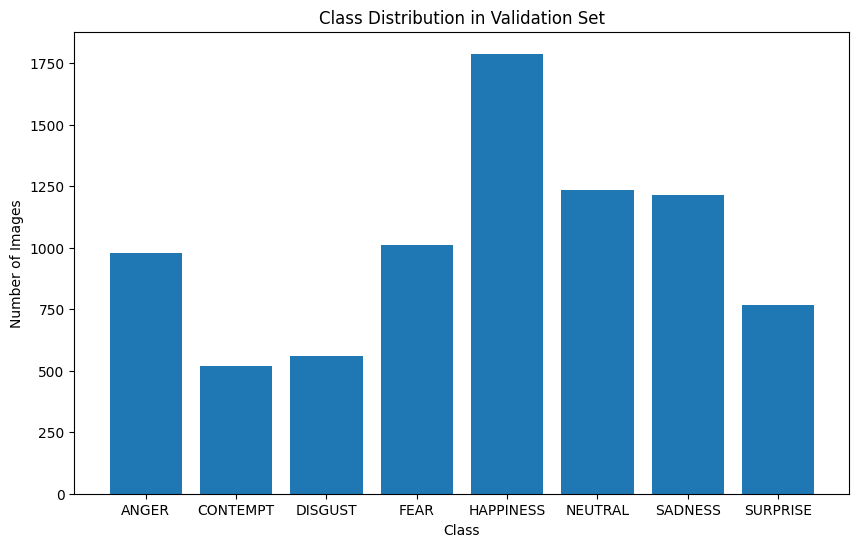

In [12]:
import matplotlib.pyplot as plt

class_counts = [len(os.listdir(os.path.join(val_path, class_name))) for class_name in validation_generator1.class_indices.keys()]

plt.figure(figsize=(10, 6))
plt.bar(validation_generator1.class_indices.keys(), class_counts)
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Class Distribution in Validation Set')
plt.show()

## Basic data exploration and summary statistics

In [13]:
# Function to calculate mean and std for images in a generator
def calculate_mean_std(generator):
    mean = 0
    std = 0
    total_samples = 0

    for images, _ in generator:
        batch_samples = images.shape[0]
        mean += images.mean() * batch_samples
        std += images.std() * batch_samples
        total_samples += batch_samples

        # Breaking after one full epoch
        if total_samples >= generator.samples:
            break

    mean /= total_samples
    std /= total_samples
    return mean, std

mean, std = calculate_mean_std(train_generator1)
print(f"Mean pixel intensity: {mean:.4f}")
print(f"Standard deviation of pixel intensity: {std:.4f}")


Mean pixel intensity: 0.5069
Standard deviation of pixel intensity: 0.2556


### Setting up a Hypothesis
#### Null Hypothesis (𝐻o): The dataset is balanced across all classes.
#### Alternate Hypothesis (𝐻𝑎): The dataset is not balanced across classes, indicating that there is a significant difference in the number of instances among the classes.

The Chi-Square test is used to determine whether there is a significant association between the different classes in the dataset.
If the Chi-Square test yields a low p-value (typically less than 0.05), it suggests that the distribution of images across classes is not random and that some classes may be over- or under-represented.

In [16]:
from scipy.stats import chisquare
import os

# Define the path to your training data
train_path = r'C:\Users\Harshitha GR\Desktop\saee\train'

# Step 1: Calculate observed frequencies (number of images in each class)
class_counts = {}
for class_name in os.listdir(train_path):
    class_path = os.path.join(train_path, class_name)
    if os.path.isdir(class_path):
        class_counts[class_name] = len(os.listdir(class_path))

# Observed frequencies
observed_frequencies = list(class_counts.values())
print("Observed frequencies (number of images in each class):", observed_frequencies)

# Step 2: Calculate expected frequencies (average count across classes)
expected_frequency = sum(observed_frequencies) / len(observed_frequencies)
expected_frequencies = [expected_frequency] * len(observed_frequencies)
print("Expected frequencies:", expected_frequencies)

# Step 3: Perform Chi-Square Test
chi2_statistic, p_value = chisquare(f_obs=observed_frequencies, f_exp=expected_frequencies)

# Output results
print("Chi-Square Statistic:", chi2_statistic)
print("p-value:", p_value)

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print("Reject the Null Hypothesis (𝐻o): The dataset is NOT balanced across all classes.")
else:
    print("Fail to Reject the Null Hypothesis (𝐻o): The dataset is balanced across all classes.")


Observed frequencies (number of images in each class): [3820, 2018, 2155, 3896, 7069, 4853, 4747, 2701]
Expected frequencies: [3907.375, 3907.375, 3907.375, 3907.375, 3907.375, 3907.375, 3907.375, 3907.375]
Chi-Square Statistic: 5041.417799673694
p-value: 0.0
Reject the Null Hypothesis (𝐻o): The dataset is NOT balanced across all classes.


#### 1) When certain classes are under-represented, models may struggle to learn their characteristics effectively, leading to biased predictions and poor generalization on unseen data.
#### 2) By augmenting the under-represented classes—through transformations such as rotation, flipping, and zooming—the dataset becomes more balanced. This enhances the model's ability to learn from a diverse range of examples within those classes, ultimately improving accuracy and robustness

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import os
import numpy as np

# Define augmentation transformations
augmenter = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)

# Define paths and classes
train_path = r'C:\Users\Harshitha GR\Desktop\saee\train' # Your training path
under_represented_classes_train = ["ANGER", "FEAR", "SADNESS", "NEUTRAL","CONTEMPT","DISGUST","SURPRISE"]  # Classes to augment
augmented_path = r'C:\Users\Harshitha GR\Desktop\saee\augmented'

# Create directory for augmented images if it doesn’t exist
os.makedirs(augmented_path, exist_ok=True)

# Set the target count as the maximum number of images in the "HAPPINESS" class
target_class = "HAPPINESS"  # The class with the most images
target_count = len(os.listdir(os.path.join(train_path, target_class)))

# Loop through each under-represented class and perform augmentation
for class_name in under_represented_classes_train:
    class_path = os.path.join(train_path, class_name)
    images = os.listdir(class_path)
    current_class_count = len(images)
    num_images_to_generate = target_count - current_class_count  # Calculate how many images to generate

    # Define path for augmented images of the current class
    class_augmented_path = os.path.join(augmented_path, class_name)
    os.makedirs(class_augmented_path, exist_ok=True)

    generated_images = 0  # Counter for generated images

    # Augment until the desired number of images is reached
    while generated_images < num_images_to_generate:
        for img_name in images:
            img_path = os.path.join(class_path, img_name)
            img = load_img(img_path, color_mode="grayscale", target_size=(48, 48))
            img_array = img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)

            # Generate and save augmented images
            for batch in augmenter.flow(img_array, batch_size=1, save_to_dir=class_augmented_path,
                                        save_prefix='aug', save_format='png'):
                generated_images += 1
                if generated_images >= num_images_to_generate:
                    break
            if generated_images >= num_images_to_generate:
                break

print("Data augmentation complete for under-represented classes.")


Data augmentation complete for under-represented classes.


#### After we are done with data augmentation, the next step is to make a combined directory, where we could copy the original images and the augmented images.
#### We would then set up a new training generator to read from the combined directory.

In [20]:
combined_data_path = r'C:\Users\Harshitha GR\Desktop\saee\combined_train_data'

# Step 1: Copying original images into the combined data directory
if not os.path.exists(combined_data_path):
    os.makedirs(combined_data_path)

for class_name in os.listdir(train_path):
    original_class_path = os.path.join(train_path, class_name)
    combined_class_path = os.path.join(combined_data_path, class_name)
    os.makedirs(combined_class_path, exist_ok=True)

    for file_name in os.listdir(original_class_path):
        file_path = os.path.join(original_class_path, file_name)
        if os.path.isfile(file_path):
          shutil.copy(file_path, combined_class_path)

# Step 2: Copy augmented images into the combined data directory
for class_name in os.listdir(augmented_path):
    augmented_class_dir = os.path.join(augmented_path, class_name)
    combined_class_dir = os.path.join(combined_data_path, class_name)

    for file_name in os.listdir(augmented_class_dir):
        file_path = os.path.join(augmented_class_dir, file_name)
        if os.path.isfile(file_path):
          shutil.copy(file_path, combined_class_dir)

print("Original and augmented data combined successfully.")



Original and augmented data combined successfully.


In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import os
import numpy as np

# Define augmentation transformations
augmenter = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)

# Define paths and classes
val_path = r'C:\Users\Harshitha GR\Desktop\saee\val'  # Your validation path
under_represented_classes_val = ["ANGER", "FEAR", "SADNESS", "NEUTRAL", "CONTEMPT", "DISGUST", "SURPRISE"]  # Classes to augment
augmented_val_path = r'C:\Users\Harshitha GR\Desktop\saee\augmented_val'

# Create directory for augmented validation images if it doesn’t exist
os.makedirs(augmented_val_path, exist_ok=True)

# Set the target count as the maximum number of images in the "HAPPINESS" class for validation
val_target_class = "HAPPINESS"  # The class with the most images
val_target_count = len(os.listdir(os.path.join(val_path, val_target_class)))

# Loop through each under-represented class and perform augmentation
for val_class_name in under_represented_classes_val:
    val_class_path = os.path.join(val_path, val_class_name)
    val_images = os.listdir(val_class_path)
    current_val_class_count = len(val_images)
    val_num_images_to_generate = val_target_count - current_val_class_count  # Calculate how many images to generate

    # Define path for augmented validation images of the current class
    val_class_augmented_path = os.path.join(augmented_val_path, val_class_name)
    os.makedirs(val_class_augmented_path, exist_ok=True)

    val_generated_images = 0  # Counter for generated images

    # Augment until the desired number of images is reached
    while val_generated_images < val_num_images_to_generate:
        for val_img_name in val_images:
            val_img_path = os.path.join(val_class_path, val_img_name)
            val_img = load_img(val_img_path, color_mode="grayscale", target_size=(48, 48))
            val_img_array = img_to_array(val_img)
            val_img_array = np.expand_dims(val_img_array, axis=0)

            # Generate and save augmented images
            for batch in augmenter.flow(val_img_array, batch_size=1, save_to_dir=val_class_augmented_path,
                                        save_prefix='aug', save_format='png'):
                val_generated_images += 1
                if val_generated_images >= val_num_images_to_generate:
                    break
            if val_generated_images >= val_num_images_to_generate:
                break

print("Data augmentation complete for under-represented validation classes.")

Data augmentation complete for under-represented validation classes.


In [22]:
import os
import shutil

# Paths for validation data
val_path = r'C:\Users\Harshitha GR\Desktop\saee\val'
augmented_val_path = r'C:\Users\Harshitha GR\Desktop\saee\augmented_val'
combined_val_data_path = r'C:\Users\Harshitha GR\Desktop\saee\combined_val_data'

# Step 1: Copying original validation images into the combined data directory
if not os.path.exists(combined_val_data_path):
    os.makedirs(combined_val_data_path)

for val_class_name in os.listdir(val_path):
    original_val_class_path = os.path.join(val_path, val_class_name)
    combined_val_class_path = os.path.join(combined_val_data_path, val_class_name)
    os.makedirs(combined_val_class_path, exist_ok=True)

    for val_file_name in os.listdir(original_val_class_path):
        val_file_path = os.path.join(original_val_class_path, val_file_name)
        if os.path.isfile(val_file_path):
            shutil.copy(val_file_path, combined_val_class_path)

# Step 2: Copy augmented validation images into the combined data directory
for val_class_name in os.listdir(augmented_val_path):
    augmented_val_class_dir = os.path.join(augmented_val_path, val_class_name)
    combined_val_class_dir = os.path.join(combined_val_data_path, val_class_name)

    for val_file_name in os.listdir(augmented_val_class_dir):
        val_file_path = os.path.join(augmented_val_class_dir, val_file_name)
        if os.path.isfile(val_file_path):
            shutil.copy(val_file_path, combined_val_class_dir)

print("Original and augmented validation data combined successfully for validation set.")

Original and augmented validation data combined successfully for validation set.


In [23]:
train_datagen1 = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True
)

train_generator2 = train_datagen1.flow_from_directory(
    combined_data_path,
    target_size=(48, 48), 
    color_mode="rgb",      
    batch_size=128,
    class_mode="categorical",
    shuffle=True          
)

print("Training generator is ready with rgb images")


Found 52173 images belonging to 8 classes.
Training generator is ready with rgb images


In [24]:
# Loading the validation images
validation_generator1 = val_datagen.flow_from_directory(
    combined_val_data_path,
    target_size=(48, 48),
    batch_size=128,
    color_mode='rgb',
    class_mode='categorical'
)

print("Validation generator is ready with rgb images")

Found 14025 images belonging to 8 classes.
Validation generator is ready with rgb images


In [25]:
# Checking the number of classes and samples in the training and validation sets
print("Training Classes and Counts:")
for class_name, count in train_generator2.class_indices.items():
    print(f"{class_name}: {len(os.listdir(os.path.join(combined_data_path, class_name)))}")

Training Classes and Counts:
ANGER: 6585
CONTEMPT: 5995
DISGUST: 6005
FEAR: 6632
HAPPINESS: 7069
NEUTRAL: 6822
SADNESS: 6830
SURPRISE: 6235


In [26]:
# Checking the number of classes and samples in the training and validation sets
print("Validation Classes and Counts:")
for class_name, count in validation_generator1.class_indices.items():
    print(f"{class_name}: {len(os.listdir(os.path.join(val_path, class_name)))}")

Validation Classes and Counts:
ANGER: 977
CONTEMPT: 521
DISGUST: 561
FEAR: 1013
HAPPINESS: 1789
NEUTRAL: 1234
SADNESS: 1214
SURPRISE: 768


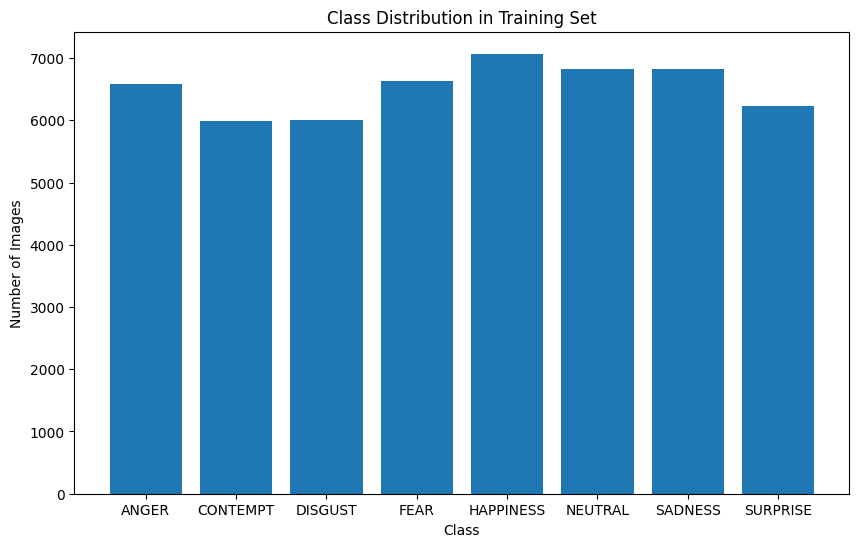

In [27]:
import matplotlib.pyplot as plt

class_counts_new = [len(os.listdir(os.path.join(combined_data_path, class_name))) for class_name in train_generator2.class_indices.keys()]

plt.figure(figsize=(10, 6))
plt.bar(train_generator2.class_indices.keys(), class_counts_new)
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Class Distribution in Training Set')
plt.show()

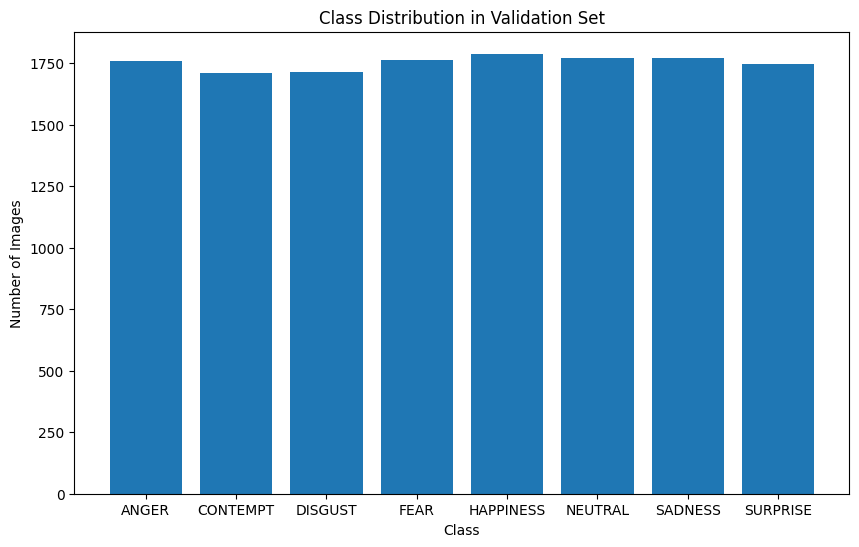

In [28]:
import matplotlib.pyplot as plt

class_counts_val = [len(os.listdir(os.path.join(combined_val_data_path, class_name))) for class_name in validation_generator1.class_indices.keys()]

plt.figure(figsize=(10, 6))
plt.bar(validation_generator1.class_indices.keys(), class_counts_val)
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Class Distribution in Validation Set')
plt.show()

#### After comparing both graphs, we can see that the imbalance between the classes has reduced.

## **MODEL TRAINING**

### Training with VGG16 model and running it with 50 epochs

In [39]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

conv_base = VGG16(
    weights='imagenet',
    include_top = False,
    input_shape=(48,48,3)
)

model = Sequential()

model.add(conv_base)
model.add(Flatten())
model.add(Dense(512,activation = 'relu'))
model.add(Dense(256,activation = 'relu'))
model.add(Dropout(0.4))
model.add(Dense(8,activation='softmax'))

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.00005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 48, 48, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [59]:
#Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.00005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


# Define callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        verbose=1
    )
]

# Training the Model
history = model.fit(
    train_generator2,
    epochs=50,
    validation_data=validation_generator1,
    callbacks=callbacks
)

# Evaluate the model
loss, accuracy = model.evaluate(validation_generator1)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

# Save the trained model
model.save('VGG_50_EPOCHS.keras')
print("Model saved as 'VGG_50_EPOCHS.keras'.")

Epoch 1/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 513s 1s/step - accuracy: 0.7007 - loss: 0.7960 - val_accuracy: 0.5795 - val_loss: 1.1192 - learning_rate: 5.0000e-05
Epoch 2/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 514s 1s/step - accuracy: 0.7173 - loss: 0.7502 - val_accuracy: 0.5958 - val_loss: 1.0631 - learning_rate: 5.0000e-05
Epoch 3/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 515s 1s/step - accuracy: 0.7316 - loss: 0.7228 - val_accuracy: 0.5852 - val_loss: 1.0879 - learning_rate: 5.0000e-05
Epoch 4/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 512s 1s/step - accuracy: 0.7360 - loss: 0.7044 - val_accuracy: 0.5996 - val_loss: 1.0586 - learning_rate: 5.0000e-05
Epoch 5/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 513s 1s/step - accuracy: 0.7442 - loss: 0.6868 - val_accuracy: 0.6098 - val_loss: 1.0387 - learning_rate: 5.0000e-05
Epoch 6/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 513s 1s/step - accuracy: 0.7462 - loss: 0.6757 - val_accuracy: 0.6297 - val_loss: 0.9823 - learning_rate: 5.0000e-05
Epoch 7/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 514s 1s/step - acc

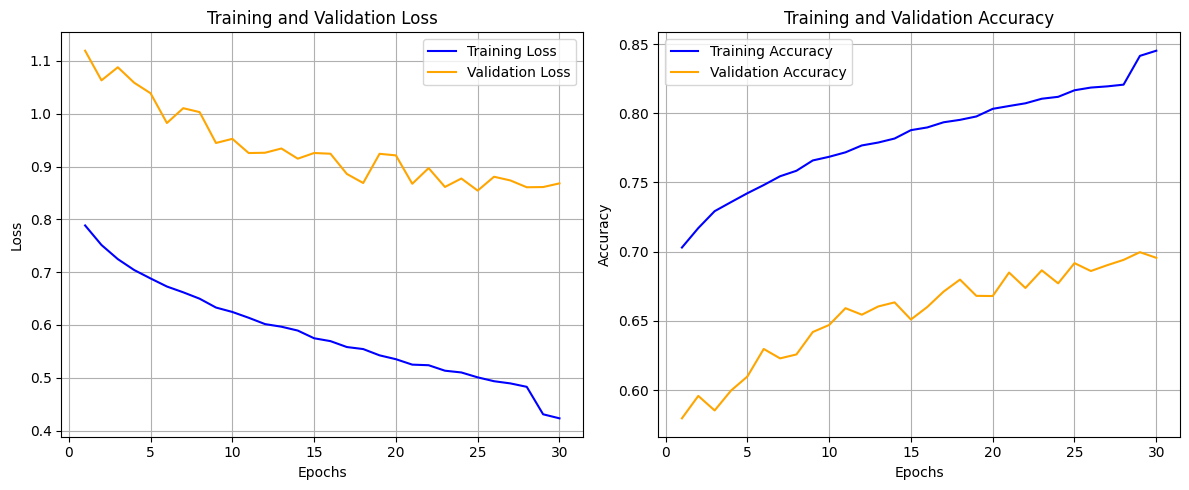

In [60]:
import matplotlib.pyplot as plt

# Retrieve metrics from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

# Plot Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Training Loss', color='blue')
plt.plot(epochs, val_loss, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, label='Training Accuracy', color='blue')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Show the plots
plt.tight_layout()
plt.show()


###  Transfer learning with ResNet50 as the base, adding custom fully connected layers, and compiling the model for 8-class image classification using categorical crossentropy and the Adam optimizer.

In [49]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

conv_base = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(48, 48, 3)
)

model_res = Sequential()

model_res.add(conv_base)
model_res.add(Flatten())
model_res.add(Dense(256,activation = 'relu'))
model_res.add(Dense(512,activation = 'relu'))
model_res.add(Dropout(0.45))
model_res.add(Dense(8,activation='softmax'))

# Compile the model
model_res.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

conv_base.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 48, 48, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 54, 54, 3) │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 24, 24,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 24, 24,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 24, 24,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 26, 26,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 12, 12,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 12, 12,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 12, 12,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 12, 12,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 12, 12,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 12, 12,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 12, 12,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 12, 12,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 12, 12,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 12, 12,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 12, 12,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [55]:
#Compile the model
model_res.compile(
    optimizer=Adam(learning_rate=0.00005),  # Small learning rate for stability
    loss='categorical_crossentropy',  # Suitable for multi-class classification
    metrics=['accuracy']
)


# Define callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        verbose=1
    )
]

# Training the Model
history = model_res.fit(
    train_generator2,
    epochs=30,
    validation_data=validation_generator1,
    callbacks=callbacks
)

# Evaluate the model
loss, accuracy = model_res.evaluate(validation_generator1)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

# Save the trained model
model.save('er_30_epochs_resnet.keras')
print("Model saved as 'er_30_epochs_resnet.keras'.")

Epoch 1/30


Exception ignored in: <function AtomicFunction.__del__ at 0x16dabc700>
Traceback (most recent call last):
  File "/Users/saeedesai/Library/Python/3.9/lib/python/site-packages/tensorflow/python/eager/polymorphic_function/atomic_function.py", line 286, in __del__
    def __del__(self):
KeyboardInterrupt: 


408/408 ━━━━━━━━━━━━━━━━━━━━ 323s 764ms/step - accuracy: 0.7352 - loss: 0.7075 - val_accuracy: 0.5737 - val_loss: 1.1315 - learning_rate: 5.0000e-05
Epoch 2/30
408/408 ━━━━━━━━━━━━━━━━━━━━ 310s 761ms/step - accuracy: 0.7367 - loss: 0.7000 - val_accuracy: 0.5953 - val_loss: 1.0619 - learning_rate: 5.0000e-05
Epoch 3/30
408/408 ━━━━━━━━━━━━━━━━━━━━ 305s 748ms/step - accuracy: 0.7399 - loss: 0.6923 - val_accuracy: 0.5937 - val_loss: 1.0906 - learning_rate: 5.0000e-05
Epoch 4/30
408/408 ━━━━━━━━━━━━━━━━━━━━ 309s 758ms/step - accuracy: 0.7493 - loss: 0.6703 - val_accuracy: 0.6026 - val_loss: 1.0547 - learning_rate: 5.0000e-05
Epoch 5/30
408/408 ━━━━━━━━━━━━━━━━━━━━ 312s 766ms/step - accuracy: 0.7466 - loss: 0.6693 - val_accuracy: 0.5997 - val_loss: 1.0734 - learning_rate: 5.0000e-05
Epoch 6/30
408/408 ━━━━━━━━━━━━━━━━━━━━ 315s 772ms/step - accuracy: 0.7537 - loss: 0.6609 - val_accuracy: 0.5991 - val_loss: 1.0767 - learning_rate: 5.0000e-05
Epoch 7/30
408/408 ━━━━━━━━━━━━━━━━━━━━ 322s 789ms/

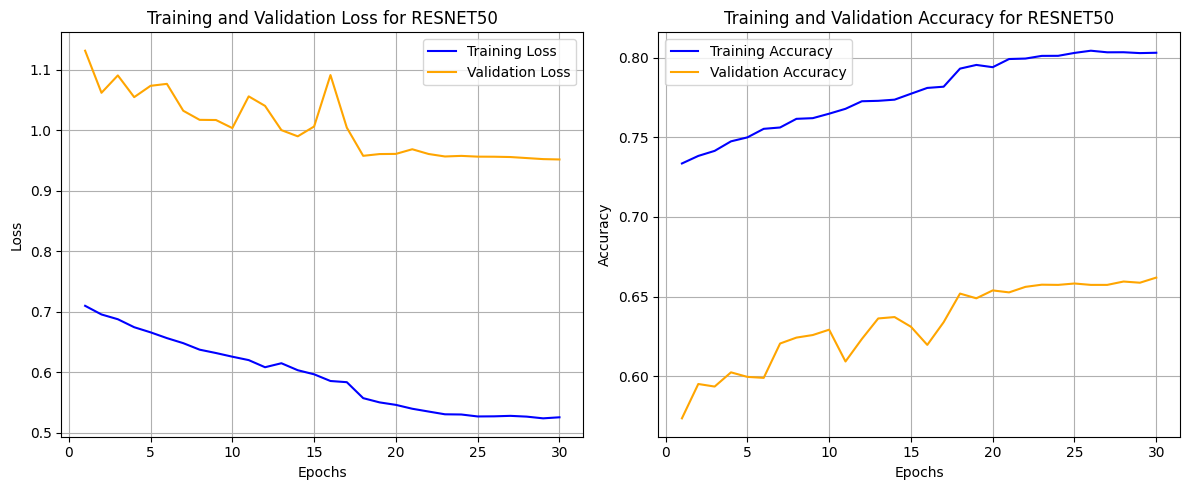

In [56]:
import matplotlib.pyplot as plt

# Retrieve metrics from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

# Plot Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Training Loss', color='blue')
plt.plot(epochs, val_loss, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss for RESNET50')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, label='Training Accuracy', color='blue')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy for RESNET50')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Show the plots
plt.tight_layout()
plt.show()

###  Transfer learning with MobileNetV2 as the base, adding custom fully connected layers, and compiling the model for 8-class image classification using categorical crossentropy and the Adam optimizer.

In [99]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

conv_base = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(48, 48, 3)
)

model_mob = Sequential()

model_mob.add(conv_base)
model_mob.add(Flatten())
model_mob.add(Dense(512,activation = 'relu'))
model_mob.add(Dense(256,activation = 'relu'))
model_mob.add(Dropout(0.45))
model_mob.add(Dense(8,activation='softmax'))

# Compile the model
model_mob.compile(
    optimizer=Adam(learning_rate=0.00005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

conv_base.summary()

/var/folders/dt/mx45884x0t9203dkrz1sq90r0000gn/T/ipykernel_6923/487814869.py:7: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  conv_base = MobileNetV2(


Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_29      │ (None, 48, 48, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 24, 24,    │        864 │ input_layer_29[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 24, 24,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 24, 24,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 24, 24,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 24, 24,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 24, 24,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 24, 24,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 24, 24,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 24, 24,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 24, 24,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 24, 24,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 25, 25,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 12, 12,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 12, 12,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 12, 12,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 12, 12,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [ ]:

# Define callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        verbose=1
    )
]

# Training the Model
history = model_mob.fit(
    train_generator2,
    epochs=100,
    validation_data=validation_generator1,
    callbacks = callbacks
)

# Evaluate the model
loss, accuracy = model_mob.evaluate(validation_generator1)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

# Save the trained model
model.save('100epochs_mobilenet.keras')
print("Model saved as '100epochs_mobilenet.keras'.")

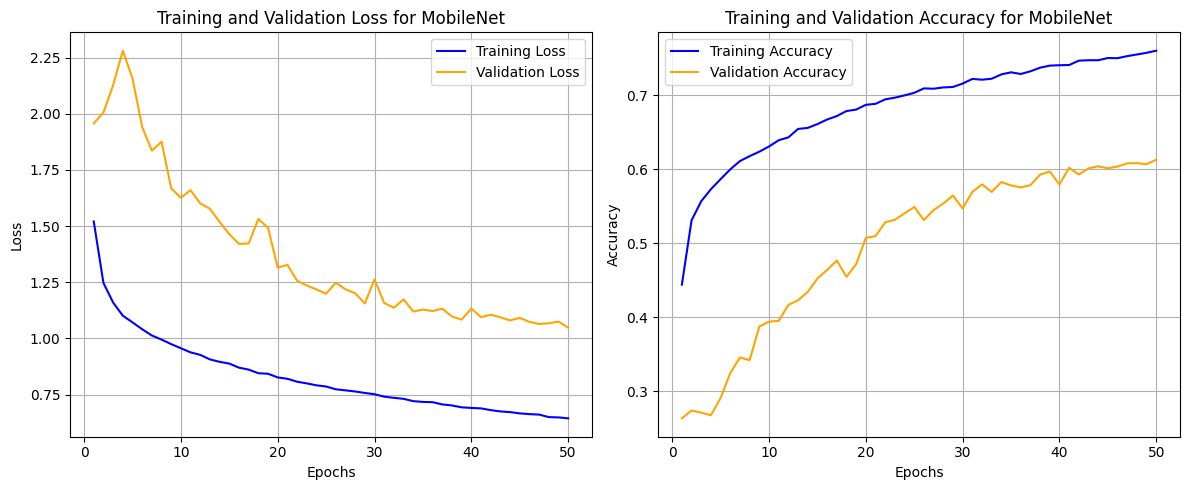

In [66]:
import matplotlib.pyplot as plt

# Retrieve metrics from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

# Plot Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Training Loss', color='blue')
plt.plot(epochs, val_loss, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss for MobileNet')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, label='Training Accuracy', color='blue')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy for MobileNet')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Show the plots
plt.tight_layout()
plt.show()

### **Using K-FOLD Cross Validation**

In [77]:
import os
import shutil

combined_dir = "/Users/saeedesai/Desktop/My codes/DATA602_FINAL_PROJECT/train_val"

# Create the combined directory
os.makedirs(combined_dir, exist_ok=True)

# Function to move files
def move_files(source_dir, target_dir):
    for class_name in os.listdir(source_dir):
        src_class_dir = os.path.join(source_dir, class_name)
        target_class_dir = os.path.join(target_dir, class_name)
        os.makedirs(target_class_dir, exist_ok=True)
        for file_name in os.listdir(src_class_dir):
            shutil.move(os.path.join(src_class_dir, file_name), target_class_dir)

# Move train and val data into combined_data
move_files(train_path, combined_dir)
move_files(val_path, combined_dir)
print("Train and Validation folders combined.")

Train and Validation folders combined.


### 5-fold cross-validation on an image classification task using a custom ConvNet2 architecture in PyTorch. The model trains for 25 epochs per fold, evaluates on validation data, and computes fold-wise metrics (loss and accuracy), followed by averaging the results.

In [78]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset, ConcatDataset
from torchvision import datasets, transforms
from sklearn.model_selection import KFold
import numpy as np

# Define your ConvNet2 model
class ConvNet2(nn.Module):
    def __init__(self):
        super(ConvNet2, self).__init__()
        self.c1 = nn.Conv2d(1, 32, 3, padding=1)
        self.c2 = nn.Conv2d(32, 64, 3, padding=1)
        self.c3 = nn.Conv2d(64, 128, 5, padding=2)
        self.c4 = nn.Conv2d(128, 512, 3, padding=1)
        self.c5 = nn.Conv2d(512, 512, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(512)
        self.bn4 = nn.BatchNorm2d(512)
        self.bn5 = nn.BatchNorm1d(256)
        self.bn6 = nn.BatchNorm1d(512)
        self.l1 = nn.Linear(512 * 3 * 3, 256)
        self.l2 = nn.Linear(256, 512)
        self.l3 = nn.Linear(512, 8)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = F.relu(self.c1(x))
        x = F.relu(self.c2(x))
        x = self.dropout(self.pool(self.bn1(x)))
        x = F.relu(self.c3(x))
        x = self.dropout(self.pool(self.bn2(x)))
        x = F.relu(self.c4(x))
        x = self.dropout(self.pool(self.bn3(x)))
        x = F.relu(self.c5(x))
        x = self.dropout(self.pool(self.bn4(x)))
        x = x.view(-1, 512 * 3 * 3)
        x = self.bn5(F.relu(self.l1(x)))
        x = self.bn6(F.relu(self.l2(x)))
        x = self.l3(x)
        return x

# Define your dataset and transforms
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = datasets.ImageFolder(combined_dir, transform=transform)

# Initialize KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Results storage
fold_results = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
    print(f"Processing Fold {fold + 1}")

    # Subset the dataset
    train_subset = Subset(dataset, train_idx)
    val_subset = Subset(dataset, val_idx)

    # Data loaders
    train_loader = DataLoader(train_subset, batch_size=128, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=128, shuffle=False)

    # Initialize the model, loss, and optimizer
    model = ConvNet2().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

    # Train the model
    for epoch in range(25):  # Adjust epochs as needed
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        
        print(f"Fold {fold + 1}, Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}")

    # Evaluate the model
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total
    print(f"Fold {fold + 1}, Validation Loss: {val_loss / len(val_loader)}, Accuracy: {val_accuracy:.2f}%")

    # Store results
    fold_results.append({"fold": fold + 1, "val_loss": val_loss / len(val_loader), "val_accuracy": val_accuracy})

# Calculate average accuracy and loss
avg_val_loss = np.mean([result["val_loss"] for result in fold_results])
avg_val_accuracy = np.mean([result["val_accuracy"] for result in fold_results])

print(f"\nAverage Validation Loss: {avg_val_loss:.4f}")
print(f"Average Validation Accuracy: {avg_val_accuracy:.2f}%")

model.save('kfold_trained.h5')


Processing Fold 1
Fold 1, Epoch 1, Loss: 1.7252393689582017
Fold 1, Epoch 2, Loss: 1.4470895591790114
Fold 1, Epoch 3, Loss: 1.3089385430018108
Fold 1, Epoch 4, Loss: 1.2194503288928087
Fold 1, Epoch 5, Loss: 1.143337916552536
Fold 1, Epoch 6, Loss: 1.0692618947203567
Fold 1, Epoch 7, Loss: 1.0111743185093733
Fold 1, Epoch 8, Loss: 0.9578879793000415
Fold 1, Epoch 9, Loss: 0.8997712542371052
Fold 1, Epoch 10, Loss: 0.8446610073248545
Fold 1, Epoch 11, Loss: 0.7806052284512094
Fold 1, Epoch 12, Loss: 0.7240517599795891
Fold 1, Epoch 13, Loss: 0.661685368394464
Fold 1, Epoch 14, Loss: 0.6060197180121895
Fold 1, Epoch 15, Loss: 0.550810551982585
Fold 1, Epoch 16, Loss: 0.4952950209863787
Fold 1, Epoch 17, Loss: 0.44522726911354843
Fold 1, Epoch 18, Loss: 0.3984773551545492
Fold 1, Epoch 19, Loss: 0.36059671610109206
Fold 1, Epoch 20, Loss: 0.3226463681435197
Fold 1, Epoch 21, Loss: 0.2880730426044968
Fold 1, Epoch 22, Loss: 0.2644820329619617
Fold 1, Epoch 23, Loss: 0.24483866165808546
Fo

AttributeError: 'ConvNet2' object has no attribute 'save'

In [79]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import KFold

# Define transforms for VGG16 (ImageNet mean and std normalization)
data_transforms = transforms.Compose([
    transforms.Resize((48, 48)),  # Resize images to 48x48
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet stats
])

# Load the dataset
dataset = ImageFolder(root=combined_dir, transform=data_transforms)
print(f"Total samples in combined dataset: {len(dataset)}")


Total samples in combined dataset: 39336


In [80]:
import torch.nn as nn
from torchvision.models import vgg16

class VGG16Model(nn.Module):
    def __init__(self, num_classes=8):
        super(VGG16Model, self).__init__()
        # Load pre-trained VGG16 model
        self.vgg = vgg16(pretrained=True)
        # Modify the classifier for 8 classes
        self.vgg.classifier[6] = nn.Linear(4096, num_classes)
    
    def forward(self, x):
        return self.vgg(x)


### 5-fold cross-validation for training a custom VGG16-based model. The dataset is split into training and validation sets for each fold, and a training loop runs for 10 epochs per fold. The model uses the Adam optimizer and cross-entropy loss.

In [84]:
from sklearn.model_selection import KFold
import torch
from torch.optim import Adam

# Define hyperparameters
k_folds = 5
batch_size = 128
learning_rate = 0.0001
num_epochs = 10

# Use KFold from sklearn
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Cross-validation loop
for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
    print(f"Fold {fold + 1}/{k_folds}")
    
    # Split dataset into training and validation subsets
    train_subset = Subset(dataset, train_idx)
    val_subset = Subset(dataset, val_idx)
    
    # Create data loaders
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
    
    # Initialize model, optimizer, and loss function
    model = VGG16Model(num_classes=8)  # Move to GPU if available
    optimizer = Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    
    # Training and validation loop
    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        
        # Training phase
        model.train()
        train_loss, train_acc = 0.0, 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs, labels
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_acc += (outputs.argmax(dim=1) == labels).float().mean().item()
        
        # Validation phase
        model.eval()
        val_loss, val_acc = 0.0, 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs, labels
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                val_acc += (outputs.argmax(dim=1) == labels).float().mean().item()
        
        print(f"Train Loss: {train_loss / len(train_loader):.4f}, Train Acc: {train_acc / len(train_loader):.4f}")
        print(f"Val Loss: {val_loss / len(val_loader):.4f}, Val Acc: {val_acc / len(val_loader):.4f}")
    
    # Save the model for the current fold
    torch.save(model.state_dict(), f"vgg16_fold_{fold + 1}.pth")
    print(f"Model for fold {fold + 1} saved.")


Fold 1/5


/Users/saeedesai/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/saeedesai/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10
Train Loss: 1.3531, Train Acc: 0.4761
Val Loss: 1.1247, Val Acc: 0.5744
Epoch 2/10
Train Loss: 1.0247, Train Acc: 0.6150
Val Loss: 1.0360, Val Acc: 0.6102
Epoch 3/10
Train Loss: 0.8338, Train Acc: 0.6922
Val Loss: 0.9957, Val Acc: 0.6471
Epoch 4/10
Train Loss: 0.6508, Train Acc: 0.7651
Val Loss: 1.0804, Val Acc: 0.6424
Epoch 5/10
Train Loss: 0.4668, Train Acc: 0.8351
Val Loss: 1.0971, Val Acc: 0.6521
Epoch 6/10
Train Loss: 0.3347, Train Acc: 0.8831
Val Loss: 1.2263, Val Acc: 0.6565
Epoch 7/10
Train Loss: 0.2366, Train Acc: 0.9206
Val Loss: 1.3543, Val Acc: 0.6575
Epoch 8/10
Train Loss: 0.1761, Train Acc: 0.9394
Val Loss: 1.5588, Val Acc: 0.6539
Epoch 9/10
Train Loss: 0.1287, Train Acc: 0.9574
Val Loss: 1.6328, Val Acc: 0.6543
Epoch 10/10
Train Loss: 0.1017, Train Acc: 0.9665
Val Loss: 1.7108, Val Acc: 0.6517
Model for fold 1 saved.
Fold 2/5
Epoch 1/10
Train Loss: 1.3505, Train Acc: 0.4743
Val Loss: 1.1151, Val Acc: 0.5754
Epoch 2/10
Train Loss: 1.0167, Train Acc: 0.6170
Val 

In [122]:
vgg_reloaded.save('vgg_reloaded_30epochs.keras')
print('Model saved successfully')

Model saved successfully


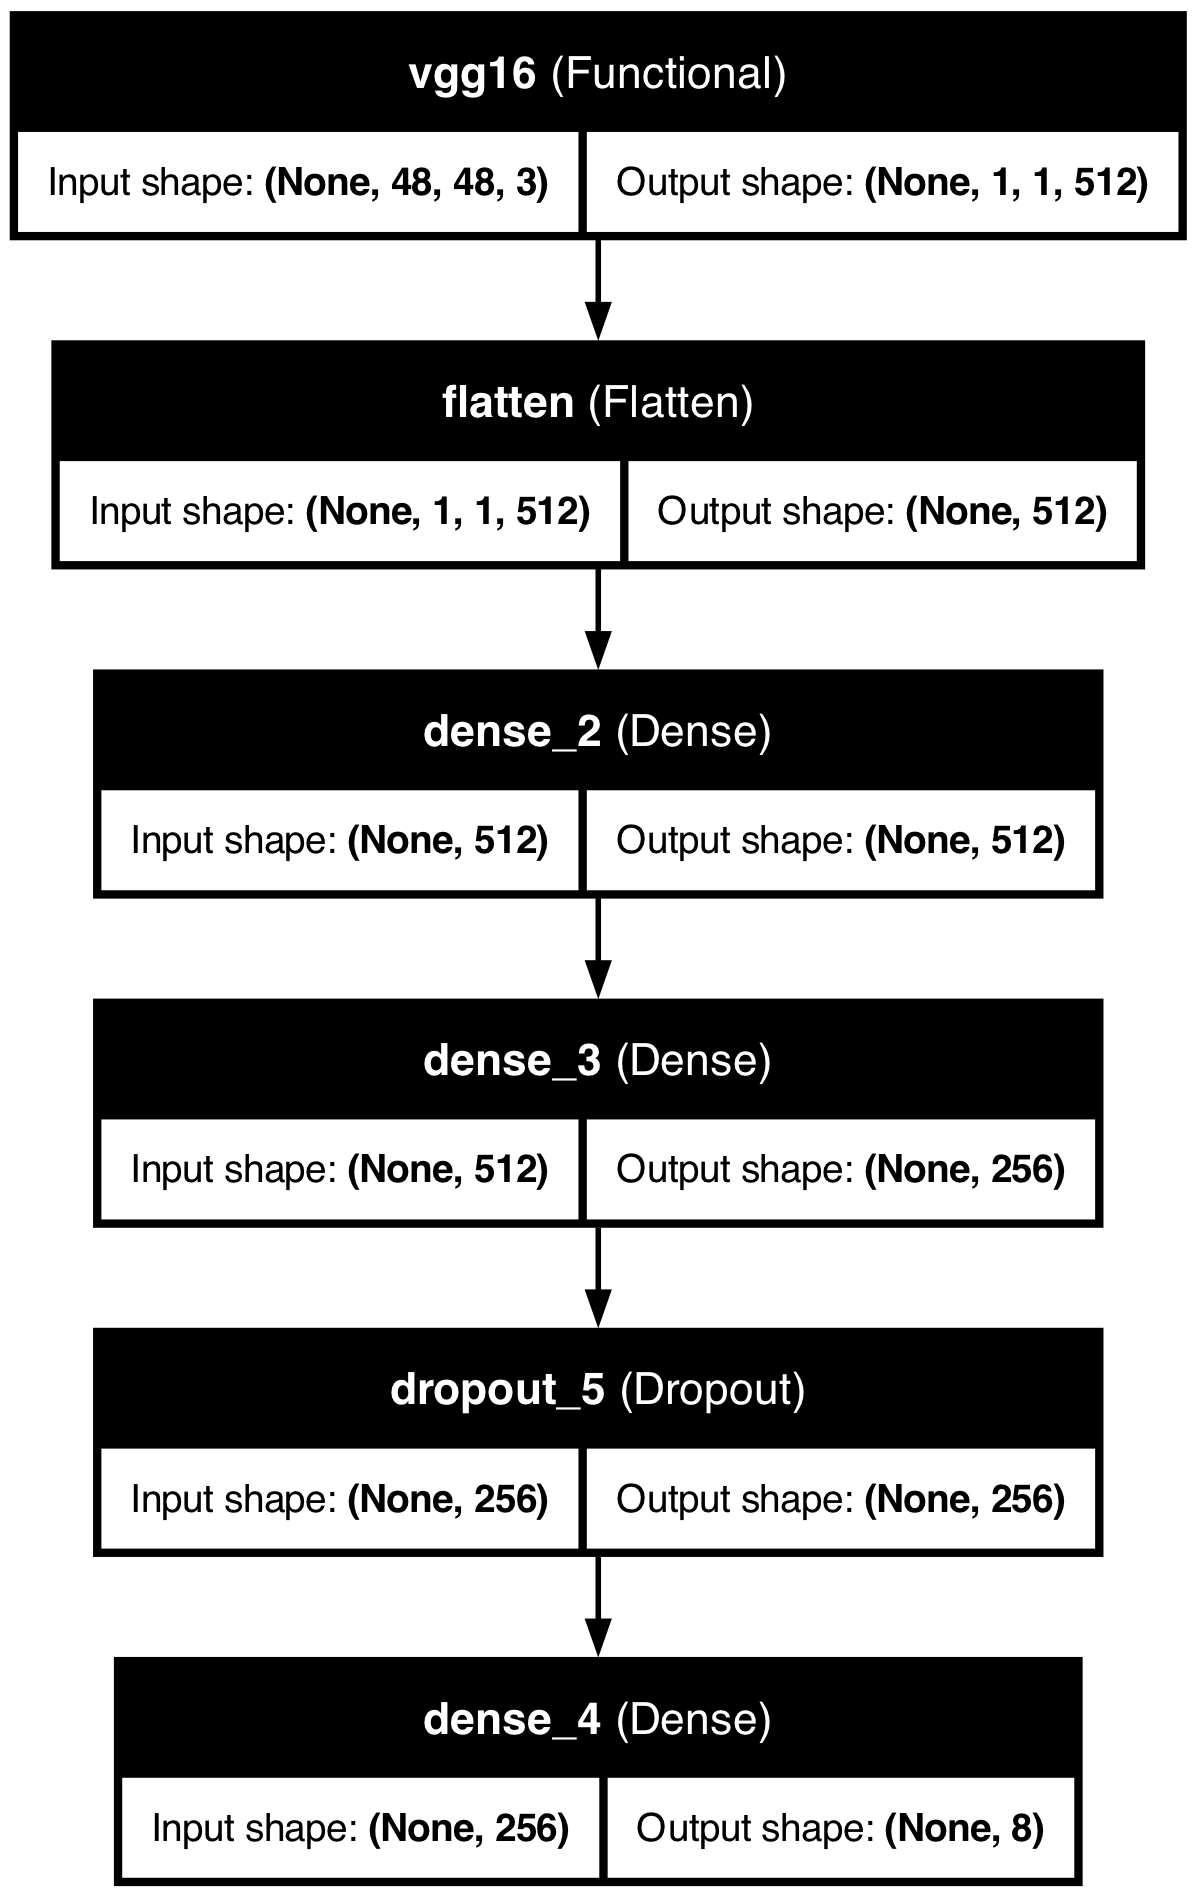

In [124]:
from keras.utils import plot_model

plot_model(vgg_reloaded, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

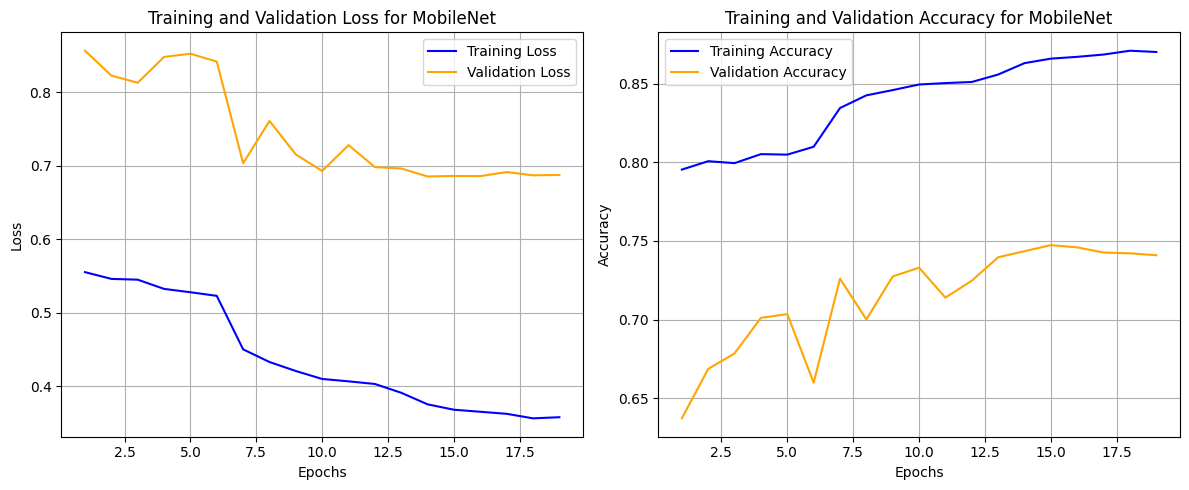

In [125]:
import matplotlib.pyplot as plt

# Retrieve metrics from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

# Plot Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Training Loss', color='blue')
plt.plot(epochs, val_loss, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss for VGG16')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, label='Training Accuracy', color='blue')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy for VGG16')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Show the plots
plt.tight_layout()
plt.show()

## Final MobileNet Model - retrained to give max accuracy.
#### Compiles and trains a MobileNetV2-based model with categorical crossentropy loss and an Adam optimizer, using callbacks for early stopping and learning rate adjustment. 

In [119]:
mob_reloaded = tf.keras.models.load_model('50epochs_mobilenet.keras')
print('Model loaded successfully')

Model loaded successfully


In [127]:
# Compile the model
mob_reloaded.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Define callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        verbose=1
    )
]

# Training the Model
history = mob_reloaded.fit(
    train_generator2,
    epochs=20,
    validation_data=validation_generator1,
    callbacks = callbacks
)

# Evaluate the model
loss, accuracy = mob_reloaded.evaluate(validation_generator1)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

# Save the trained model
mob_reloaded.save('20_epochs_mobilenet_reloaded.keras')
print('Model saved as 20_epochs_model.keras')

Epoch 1/20
408/408 ━━━━━━━━━━━━━━━━━━━━ 533s 1s/step - accuracy: 0.8241 - loss: 0.4850 - val_accuracy: 0.7135 - val_loss: 0.8259 - learning_rate: 1.0000e-04
Epoch 2/20
408/408 ━━━━━━━━━━━━━━━━━━━━ 529s 1s/step - accuracy: 0.8255 - loss: 0.4789 - val_accuracy: 0.7249 - val_loss: 0.7452 - learning_rate: 1.0000e-04
Epoch 3/20
408/408 ━━━━━━━━━━━━━━━━━━━━ 510s 1s/step - accuracy: 0.8249 - loss: 0.4751 - val_accuracy: 0.7375 - val_loss: 0.7257 - learning_rate: 1.0000e-04
Epoch 4/20
408/408 ━━━━━━━━━━━━━━━━━━━━ 507s 1s/step - accuracy: 0.8286 - loss: 0.4669 - val_accuracy: 0.6951 - val_loss: 0.8551 - learning_rate: 1.0000e-04
Epoch 5/20
408/408 ━━━━━━━━━━━━━━━━━━━━ 507s 1s/step - accuracy: 0.8287 - loss: 0.4711 - val_accuracy: 0.7132 - val_loss: 0.7787 - learning_rate: 1.0000e-04
Epoch 6/20
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8336 - loss: 0.4545
Epoch 6: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
408/408 ━━━━━━━━━━━━━━━━━━━━ 507s 1s/step - accuracy:

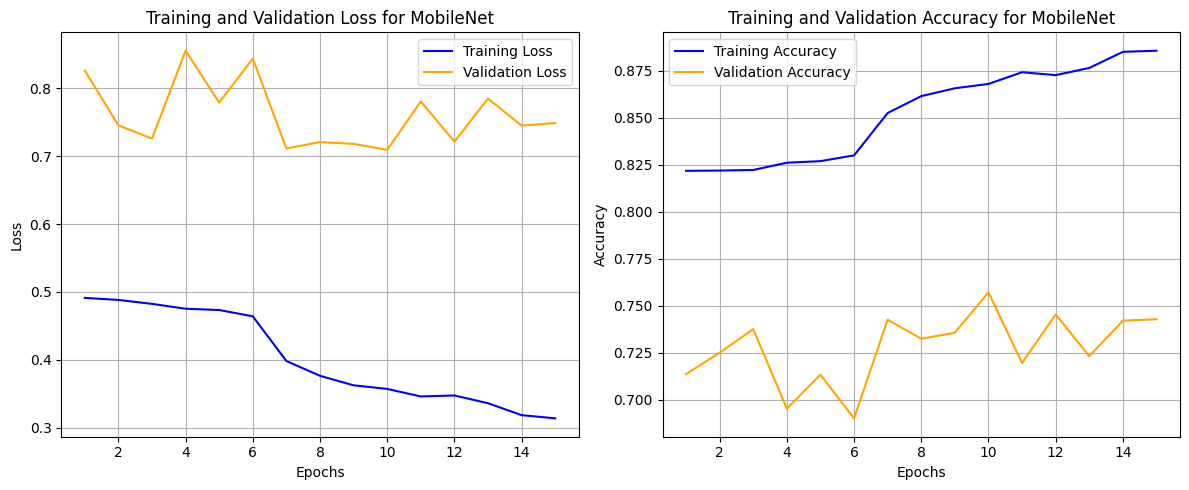

In [128]:
import matplotlib.pyplot as plt

# Retrieve metrics from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

# Plot Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Training Loss', color='blue')
plt.plot(epochs, val_loss, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss for MobileNet')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, label='Training Accuracy', color='blue')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy for MobileNet')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Show the plots
plt.tight_layout()
plt.show()